In [2]:
import os
import csv
import json
import numpy as np
import torch
import open_clip
import argparse
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import faiss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [7]:
class Flickr30kDataset(Dataset):
    """
    Custom Dataset for Flickr30k images and captions.
    """
    def __init__(self, image_dir, captions_csv, preprocess, sample_one_caption=True):
        """
        Args:
            image_dir (str): Directory containing images.
            captions_csv (str): Path to the results.csv file.
            preprocess (torch.nn.Module): CLIP preprocessing pipeline.
            sample_one_caption (bool): Whether to sample one caption per image.
        """
        self.image_dir = image_dir
        self.preprocess = preprocess
        self.sample_one_caption = sample_one_caption
        self.image_ids = []
        self.image_paths = []
        self.captions = []
        self._load_data(captions_csv)

    def set_image_or_caption(self, image_or_caption):
        """
        Set whether to return images or captions.
        """
        self.image_or_caption = image_or_caption

    def _load_data(self, captions_csv):
        """
        Loads and parses the captions CSV file.
        """
        print(f"Loading captions from {captions_csv}...")
        df = pd.read_csv(captions_csv, sep='|', header=None, names=['image_name', 'comment_number', 'comment'])
        
        # Group captions by image_name
        grouped = df.groupby('image_name')
        
        for image_name, group in tqdm(grouped, desc="Processing Captions"):
            image_path = os.path.join(self.image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"Warning: Image file {image_path} does not exist. Skipping.")
                continue
            if self.sample_one_caption:
                # Sample the first caption
                caption = group.sort_values('comment_number').iloc[0]['comment']
                self.image_ids.append(image_name)
                self.image_paths.append(image_path)
                self.captions.append(caption)
            else:
                # Include all captions (for extended experiments)
                for _, row in group.sort_values('comment_number').iterrows():
                    self.image_ids.append(image_name)
                    self.image_paths.append(image_path)
                    self.captions.append(row['comment'])
    
        print(f"Total valid image-caption pairs: {len(self.image_ids)}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Preprocessed image tensor.
            caption (str): Corresponding caption.
            image_id (str): Unique image identifier.
        """
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        image_id = self.image_ids[idx]
        if self.image_or_caption == "image":
            image = Image.open(image_path).convert('RGB')
            image = self.preprocess(image)
            return image, image_id # image_id is the unique identifier for the image
        elif self.image_or_caption == "caption":
            return caption, image_id # image_id is the relevant image identifier for the caption
        else:
            raise ValueError("image_or_caption must be either 'image' or 'caption'.")


class COCODataset(Dataset):
        """
        Custom Dataset for loading and preprocessing MS COCO images.
        """
        def __init__(self, image_dir, captions_json_path, preprocess):
            self.image_ids, self.image_paths, self.captions = self._load_data(captions_json_path, image_dir)
            self.preprocess = preprocess

        def set_image_or_caption(self, image_or_caption):
            """
            Set whether to return images or captions.
            """
            self.image_or_caption = image_or_caption

        def _load_data(self, captions_json_path, image_dir):
            """
            Loads the MS COCO captions and maps image IDs to file names and captions.

            Args:
                captions_json_path (str): Path to the captions.json file.
                image_dir (str): Directory where images are stored.

            Returns:
                image_ids (list): List of image IDs.
                image_paths (list): List of image file paths corresponding to image IDs.
                captions (list): List of sampled captions corresponding to image IDs.
            """
            print(f"Loading captions from {captions_json_path}...")
            with open(captions_json_path, 'r') as f:
                data = json.load(f)

            # Create a mapping from image_id to file_name
            image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}

            # Create a mapping from image_id to list of captions
            image_id_to_captions = {}
            for ann in data['annotations']:
                img_id = ann['image_id']
                caption = ann['caption']
                if img_id in image_id_to_captions:
                    image_id_to_captions[img_id].append(caption)
                else:
                    image_id_to_captions[img_id] = [caption]

            image_ids = []
            image_paths = []
            captions = []

            print("Processing images and captions...")
            for img_id, file_name in tqdm(image_id_to_filename.items(), desc="Images"):
                image_path = os.path.join(image_dir, file_name)
                if not os.path.exists(image_path):
                    print(f"Warning: Image file {image_path} does not exist. Skipping.")
                    continue
                if img_id not in image_id_to_captions:
                    print(f"Warning: No captions found for image ID {img_id}. Skipping.")
                    continue
                sampled_caption = image_id_to_captions[img_id][0]  # Sample the first caption
                image_ids.append(img_id)
                image_paths.append(image_path)
                captions.append(sampled_caption)

            print(f"Total valid images with captions: {len(image_ids)}")
            return image_ids, image_paths, captions

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            caption = self.captions[idx]
            image_id = self.image_ids[idx]
            if self.image_or_caption == "image":
                image = Image.open(image_path).convert('RGB')
                image = self.preprocess(image)
                return image, image_id # image_id is the unique identifier for the image
            elif self.image_or_caption == "caption":
                return caption, image_id # image_id is the relevant image identifier for the caption
            else:
                raise ValueError("image_or_caption must be either 'image' or 'caption'.")
            

def collate_fn(batch):
    """
    Custom collate function to filter out failed image loads.
    """
    images_or_captions = []
    image_ids = []
    for item in batch:
        thing, image_id = item
        images_or_captions.append(thing)
        image_ids.append(image_id)
    if not isinstance(images_or_captions[0], str):
        images_or_captions = torch.stack(images_or_captions, dim=0)
    return images_or_captions, image_ids


def embed_images(model, dataset, device, batch_size=64, num_workers=4):
    """
    Embeds images using CLIP and saves the embeddings to a memmap file.
    Utilizes a DataLoader for efficient parallel loading and preprocessing of images.

    Args:
        model (clip.model.CLIP): The CLIP model.
        dataset (Flickr30kDataset): The Flickr30k dataset object.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        batch_size (int, optional): Number of images to process per batch. Defaults to 64.
        num_workers (int, optional): Number of subprocesses to use for data loading. Defaults to 4.
    """
    # Initialize the DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn
    )

    num_images = len(dataset)

    image_embeddings = None

    print("Embedding images...")
    # Create a mapping from image_id to index for alignment
    image_ids = []

    for images, image_ids_batch in tqdm(dataloader, desc="Embedding Images"):
        if images.size(0) == 0:
            continue  # Skip if no images in the batch

        # Move images to the specified device
        images = images.to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            # Encode images using CLIP
            image_features = model.encode_image(images)  # Shape: [batch_size, embedding_dim]
            # Normalize the embeddings to unit vectors
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            # Move embeddings to CPU and convert to NumPy
            image_features = image_features.cpu().numpy()

        if image_embeddings is None:
            embedding_dim = image_features.shape[1]
            image_embeddings = np.zeros((num_images, embedding_dim), dtype='float32')
        # Save embeddings to the memmap at the corresponding indices
        image_embeddings[len(image_ids):len(image_ids) + image_features.shape[0], :] = image_features
        image_ids.extend(image_ids_batch)

    return image_embeddings, image_ids


def embed_captions(model, tokenizer: open_clip.tokenizer, dataset, device, batch_size=256):
    """
    Embeds captions using CLIP and saves the embeddings to a memmap file.

    Args:
        model (clip.model.CLIP): The CLIP model.
        dataset (Flickr30kDataset): The Flickr30k dataset object.
        memmap_path (str): Path to save the text embeddings.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        batch_size (int, optional): Number of captions to process per batch. Defaults to 256.
    """
    # Initialize the DataLoader for captions
    # Since captions are associated with images, we'll iterate over the dataset
    # and collect captions in batches
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        collate_fn=collate_fn
    )

    num_captions = len(dataset)
    text_embeddings = None

    print("Embedding captions...")
    # Create a mapping from image_id to index for alignment
    all_rel_image_ids = []
    all_captions = []

    for captions_batch, image_ids_batch in tqdm(dataloader, desc="Embedding Captions"):
        # Tokenize captions
        text_tokens = tokenizer(captions_batch).to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            # Encode text using CLIP
            text_features = model.encode_text(text_tokens)  # Shape: [batch_size, embedding_dim]
            # Normalize the embeddings to unit vectors
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            # Move embeddings to CPU and convert to NumPy
            text_features = text_features.cpu().numpy()

        if text_embeddings is None:
            embedding_dim = text_features.shape[1]
            
            text_embeddings = np.zeros((num_captions, embedding_dim), dtype='float32')

        # Save embeddings to the memmap at the corresponding indices
        text_embeddings[len(all_captions):len(all_captions) + text_features.shape[0], :] = text_features
        all_captions.extend(captions_batch)
        all_rel_image_ids.extend(image_ids_batch)

    return text_embeddings, all_captions, all_rel_image_ids






In [8]:
dataset = "mscoco"

## The paths to the images directory and captions file

if dataset == "flickr30k":
    # Paths to the images directory and results.csv
    IMAGE_DIR = "/home/zjt/datasets/flickr/flickr30k_images/flickr30k_images/"      # Replace with your actual images directory path
    CAPTIONS_CSV = "/home/zjt/datasets/flickr/flickr30k_images/results.csv"  # Replace with your actual results.csv path
    dataset = Flickr30kDataset(
        image_dir=IMAGE_DIR,
        captions_csv=CAPTIONS_CSV,
        preprocess=None,  # Will set after loading CLIP
        sample_one_caption=True  # Sample one caption per image
    )
elif "mscoco" in dataset:
    split = "validation"
    IMAGE_DIR = f"/home/zjt/fiftyone/coco-2017/{split}/data/"  # Replace with your actual image directory path
    if split == "validation":
        CAPTIONS_JSON = f"/home/zjt/fiftyone/coco-2017/raw/captions_val2017.json"
    elif split == "train":
        CAPTIONS_JSON = f"/home/zjt/fiftyone/coco-2017/raw/captions_{split}2017.json"  # Replace with your actual captions.json path
    else:
        raise ValueError("Only MSCOCO train and validation splits are supported.")
    dataset = COCODataset(
        image_dir=IMAGE_DIR,
        captions_json_path=CAPTIONS_JSON,
        preprocess=None  # Will set after loading CLIP
    )
else:
    raise ValueError("Dataset must be either 'flickr30k' or 'mscoco'.")



Loading captions from /home/zjt/fiftyone/coco-2017/raw/captions_val2017.json...
Processing images and captions...


Images: 100%|██████████| 5000/5000 [00:00<00:00, 211771.50it/s]

Total valid images with captions: 5000


In [9]:
# Device Configuration
DEVICE = f"cuda:0"

# Initialize CLIP Model
print("Loading CLIP model...")
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-16-quickgelu", "openai", device=DEVICE)
model.eval()
tokenizer = open_clip.get_tokenizer("ViT-B-16-quickgelu")

# Assign the preprocess function to the dataset
dataset.preprocess = preprocess

# Embed Images and Save to Memmap
print("Embedding images...")
dataset.set_image_or_caption("image")
image_embeddings, image_ids = embed_images(
    model=model,
    dataset=dataset,
    device=DEVICE,
    batch_size=16,
    num_workers=4,
)

dataset.set_image_or_caption("caption")
text_embeddings, all_captions, all_rel_image_ids = embed_captions(
    model=model,
    tokenizer=tokenizer,
    dataset=dataset,
    device=DEVICE,
    batch_size=16,
)

Loading CLIP model...
Embedding images...
Embedding images...


Embedding Images:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_2366480/4092043514.py:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Embedding Images: 100%|██████████| 313/313 [00:16<00:00, 19.15it/s]


Embedding captions...


Embedding Captions:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_2366480/4092043514.py:267: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Embedding Captions: 100%|██████████| 313/313 [00:05<00:00, 52.43it/s]


In [22]:

index = faiss.IndexFlatIP(image_embeddings.shape[1])
index.add(image_embeddings)  # Add all image embeddings to the index

# Create a mapping from image_id to its index for quick lookup
print("Creating image_id to index mapping...")
image_id_to_index = {img_id: idx for idx, img_id in enumerate(image_ids)}

# Initialize a list to store the rank of the true image for each query
text_to_image_failure_cnts = []

num_queries = text_embeddings.shape[0]
total_images = image_embeddings.shape[0]

search_batch_size = 32

# Process queries in batches to manage memory usage
for start in tqdm(range(0, num_queries, search_batch_size), desc="Processing Batches"):
    end = min(start + search_batch_size, num_queries)
    batch_text = text_embeddings[start:end]

    # Perform search: retrieve all image indices sorted by similarity
    D, I = index.search(batch_text, min(total_images, 50000))

    for i in range(end - start):
        query_image_id = all_rel_image_ids[start + i]
        # Get the correct image index for this query
        correct_index = image_id_to_index.get(query_image_id, -1)

        if correct_index == -1:
            # If the image ID is not found, assign a rank of -1
            rank = -1
        else:
            # Find the position of the correct image in the retrieved list
            # FAISS returns indices sorted by descending similarity
            rank_position = np.where(I[i] == correct_index)[0]
            if rank_position.size > 0:
                # +1 for 1-based ranking
                rank = int(rank_position[0] + 1)
            else:
                # If not found in the retrieved list, assign rank as -1
                rank = -1

        text_to_image_failure_cnts.append(rank - 1)

Creating image_id to index mapping...


Processing Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Processing Batches: 100%|██████████| 157/157 [00:04<00:00, 38.19it/s]


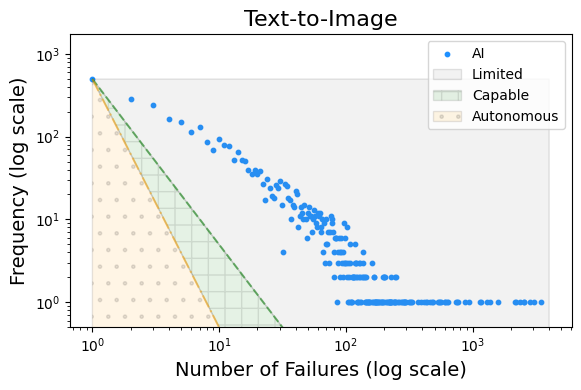

In [25]:
import matplotlib.pyplot as plt
import numpy as np

frequency = np.zeros(max(text_to_image_failure_cnts) + 1)
for cnt in text_to_image_failure_cnts:
    if cnt > 0 and cnt < len(frequency):
        frequency[cnt] += 1

plt.figure(figsize=(6, 4))

x = np.array(range(1, 4000))
# Plot histogram
plt.scatter(x, frequency[x], color="dodgerblue", s=10, label="AI")

y1 = (x.astype(np.float32))**-2 * frequency[1]
y2 = (x.astype(np.float32))**-3 * frequency[1]

# 绘制两条分界线, # label=r'$y \propto x^{-2}$',# label=r'$y \propto x^{-3}$',
plt.plot(x, y1,  color='green', linestyle='--', alpha=0.5) 
plt.plot(x, y2,  color='orange', linestyle='-.', alpha=0.5) 

# 填充不同区域
plt.fill_between(x, frequency[1], y1, color='gray', alpha=0.1, label="Limited", edgecolor="black")
plt.fill_between(x, y1, y2, color='green', alpha=0.1, hatch='+', label="Capable", edgecolor="black")
plt.fill_between(x, y2,0, color='orange', alpha=0.1, hatch='.', label="Autonomous", edgecolor="black")

# Set x-axis to log scale
plt.xscale('log')
# Set y-axis to log scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Failures (log scale)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.title(f'Text-to-Image', fontsize=16)

plt.tight_layout()

plt.legend(loc='upper right')

# set ylim lower bound to min(frequency)
plt.ylim(bottom=min(frequency[frequency > 0] / 2))

plt.show()
